In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
# Fill in the path in your Google Drive in the string below
import os
datadir = "/path"
if not os.path.exists(datadir):
  !ln -s "/path" $datadir
os.chdir(datadir)
!pwd

In [ ]:
VOC_PATH="/path"

!chmod u+x ./download_data.sh
!sed -i 's/\r//g' ./download_data.sh
!cat ./download_data.sh
!bash ./download_data.sh $VOC_PATH

In [ ]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader

from src.resnet_yolo import resnet50
import yolo_loss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

In [ ]:
learning_rate = 0.001
num_epochs = 50
batch_size = 16

# YOLO loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a relatively small dataset (5,000 images in train and validation combined), the train and validation splits were merged to train the detector. Although this is generally not considered best practice, an exception was made in this case to achieve reasonable detection performance given the limited dataset size.

The training data loader applies a variety of data augmentation techniques, including random shifts, scaling, cropping, and flipping. Data augmentation for detection datasets is slightly more complex, as the bounding box annotations must remain consistent throughout the transformations.

Because the output of the trained detector network is structured as an S×S×(B×5+C) tensor, an encoder is used to convert the original bounding box coordinates into relative grid bounding box coordinates aligned with the network’s expected output. A corresponding decoder is also implemented to map the predictions back into image coordinate bounding boxes.

In [ ]:
file_root_train = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007/JPEGImages/')
annotation_file_train = '/path/data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [ ]:
file_root_test = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007test/JPEGImages/')
annotation_file_test = '/path/data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [ ]:
data = train_dataset[0]

## Initializing the network

To implement YOLO, a pretrained classifier is used as the backbone for the detection network. PyTorch provides a variety of models pretrained on ImageNet through the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In this implementation, the ResNet-50 architecture is selected as the base for the detector. This choice differs from the original YOLO paper, resulting in a different output grid size (14×14 instead of 7×7).

Models are typically pretrained on ImageNet due to the dataset’s large size (over 1 million images) and widespread use. A pretrained model offers a valuable weight initialization for the detector, enabling the network to learn more quickly and effectively.

In [ ]:
load_network_path = None
pretrained = True

# Use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


## Set up training tools

In [ ]:
from importlib import reload
reload(yolo_loss)

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [ ]:
best_test_loss = np.inf
learning_rate = learning_rate

os.makedirs('./checkpoints', exist_ok=True)
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')





Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/314], Loss: total=24.658, reg=4.089, containing_obj=0.272, no_obj=12.423, cls=7.874
Epoch [1/50], Iter [100/314], Loss: total=16.719, reg=3.692, containing_obj=0.350, no_obj=6.432, cls=6.245
Epoch [1/50], Iter [150/314], Loss: total=13.554, reg=3.366, containing_obj=0.396, no_obj=4.390, cls=5.401
Epoch [1/50], Iter [200/314], Loss: total=11.777, reg=3.140, containing_obj=0.443, no_obj=3.353, cls=4.840
Epoch [1/50], Iter [250/314], Loss: total=10.650, reg=2.989, containing_obj=0.477, no_obj=2.723, cls=4.462
Epoch [1/50], Iter [300/314], Loss: total=9.806, reg=2.870, containing_obj=0.503, no_obj=2.298, cls=4.134
Updating best test loss: 5.47361


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/314], Loss: total=5.373, reg=2.213, containing_obj=0.678, no_obj=0.149, cls=2.334
Epoch [2/50], Iter [100/314], Loss: total=5.303, reg=2.194, containing_obj=0.674, no_obj=0.141, cls=2

100%|██████████| 4950/4950 [02:04<00:00, 39.71it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.021641069118813923---
---class bird ap 0.002904865649963689---
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0---
---class bus ap 0.0---
---class car ap 0.14159159375074162---
---class cat ap 0.002793296089385475---
---class chair ap 0.011026756455216684---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.054664985213152585---
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0864729003092819---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0--- (no predictions for this class)
---map 0.016054773329327796---
4 [np.float64(0.0)

100%|██████████| 4950/4950 [02:06<00:00, 39.01it/s]


---class aeroplane ap 0.2954878380687809---
---class bicycle ap 0.3906863264079975---
---class bird ap 0.25951421322985413---
---class boat ap 0.06814605518789697---
---class bottle ap 0.04021835462876994---
---class bus ap 0.31420595859108624---
---class car ap 0.43544761774211094---
---class cat ap 0.5818925980156813---
---class chair ap 0.17152173618774574---
---class cow ap 0.18918417257305722---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.5242226674378967---
---class horse ap 0.5356187472000762---
---class motorbike ap 0.47040550624559224---
---class person ap 0.32568483812694027---
---class pottedplant ap 0.03264572288230517---
---class sheep ap 0.2084808657691644---
---class sofa ap 0.23688166414086295---
---class train ap 0.4331784816277031---
---class tvmonitor ap 0.26460333380254336---
---map 0.2889013348933032---
9 [np.float64(0.2954878380687809), np.float64(0.3906863264079975), np.float64(0.25951421322985413), np.float64(0.06814605518789

100%|██████████| 4950/4950 [02:09<00:00, 38.37it/s]


---class aeroplane ap 0.4049529896340561---
---class bicycle ap 0.4746763859551457---
---class bird ap 0.3957796963178283---
---class boat ap 0.14760954168255164---
---class bottle ap 0.0681176611490293---
---class bus ap 0.46441895779979314---
---class car ap 0.5733370925636645---
---class cat ap 0.5953238919582016---
---class chair ap 0.216774246014468---
---class cow ap 0.36500142360967586---
---class diningtable ap 0.12500618383296352---
---class dog ap 0.6318274755248371---
---class horse ap 0.6307894213128927---
---class motorbike ap 0.5029904761828147---
---class person ap 0.37493861384487653---
---class pottedplant ap 0.06861852228708562---
---class sheep ap 0.2018220709453063---
---class sofa ap 0.31140355499250644---
---class train ap 0.5164651585818678---
---class tvmonitor ap 0.36014050671807185---
---map 0.37149969354538187---
14 [np.float64(0.4049529896340561), np.float64(0.4746763859551457), np.float64(0.3957796963178283), np.float64(0.14760954168255164), np.float64(0.06

100%|██████████| 4950/4950 [02:08<00:00, 38.51it/s]


---class aeroplane ap 0.41053319325995974---
---class bicycle ap 0.48009379791896867---
---class bird ap 0.4222395886597422---
---class boat ap 0.23376407907895086---
---class bottle ap 0.12055775384611488---
---class bus ap 0.5619551964603084---
---class car ap 0.5836104834267418---
---class cat ap 0.6426074501714181---
---class chair ap 0.2613134127669055---
---class cow ap 0.44384234118762134---
---class diningtable ap 0.2712383666335171---
---class dog ap 0.6427283130506901---
---class horse ap 0.6207731380285713---
---class motorbike ap 0.45247161896819466---
---class person ap 0.3891135368513928---
---class pottedplant ap 0.10412952021698982---
---class sheep ap 0.3591864070337415---
---class sofa ap 0.3522442219198169---
---class train ap 0.5602061391426933---
---class tvmonitor ap 0.4355162272232114---
---map 0.41740623929227744---
19 [np.float64(0.41053319325995974), np.float64(0.48009379791896867), np.float64(0.4222395886597422), np.float64(0.23376407907895086), np.float64(0.

100%|██████████| 4950/4950 [02:07<00:00, 38.69it/s]


---class aeroplane ap 0.4434280651986138---
---class bicycle ap 0.595708612231518---
---class bird ap 0.4409543027341878---
---class boat ap 0.30010192306954564---
---class bottle ap 0.14521910595647375---
---class bus ap 0.6106913783383117---
---class car ap 0.6401030496096587---
---class cat ap 0.6994570590617852---
---class chair ap 0.26362234933743145---
---class cow ap 0.4233410330090705---
---class diningtable ap 0.33255886960696834---
---class dog ap 0.6401682915132239---
---class horse ap 0.6345384567007595---
---class motorbike ap 0.4995896932287423---
---class person ap 0.43075143152462886---
---class pottedplant ap 0.12636241860326175---
---class sheep ap 0.3499395160468699---
---class sofa ap 0.43790097774804204---
---class train ap 0.6615043895822426---
---class tvmonitor ap 0.4891598688365669---
---map 0.4582550395968951---
24 [np.float64(0.4434280651986138), np.float64(0.595708612231518), np.float64(0.4409543027341878), np.float64(0.30010192306954564), np.float64(0.14521

100%|██████████| 4950/4950 [02:09<00:00, 38.20it/s]


---class aeroplane ap 0.40027365862537073---
---class bicycle ap 0.6052876860041758---
---class bird ap 0.4582883647520546---
---class boat ap 0.30053066940239775---
---class bottle ap 0.150760224629234---
---class bus ap 0.5885930424972902---
---class car ap 0.6701922586825062---
---class cat ap 0.4379244737656881---
---class chair ap 0.2862500206913116---
---class cow ap 0.4412331925746408---
---class diningtable ap 0.3800626959434822---
---class dog ap 0.6369667055296002---
---class horse ap 0.6467816714297505---
---class motorbike ap 0.5032578481054684---
---class person ap 0.4194943096660332---
---class pottedplant ap 0.14627304617833625---
---class sheep ap 0.3441153728428621---
---class sofa ap 0.48542494458097607---
---class train ap 0.6530811333114286---
---class tvmonitor ap 0.47674929015786094---
---map 0.4515770304685233---
29 [np.float64(0.40027365862537073), np.float64(0.6052876860041758), np.float64(0.4582883647520546), np.float64(0.30053066940239775), np.float64(0.15076

100%|██████████| 4950/4950 [02:08<00:00, 38.53it/s]


---class aeroplane ap 0.4372050922695375---
---class bicycle ap 0.6197545161951739---
---class bird ap 0.48225904844327533---
---class boat ap 0.2970871487951257---
---class bottle ap 0.1696013435152286---
---class bus ap 0.655269444782057---
---class car ap 0.6696395472620749---
---class cat ap 0.7042929934867903---
---class chair ap 0.2942146993968513---
---class cow ap 0.540132257095181---
---class diningtable ap 0.3928284175148746---
---class dog ap 0.6501163375191095---
---class horse ap 0.6785072179068308---
---class motorbike ap 0.5722248522872335---
---class person ap 0.5243367595262026---
---class pottedplant ap 0.18834725930281454---
---class sheep ap 0.42625678657220484---
---class sofa ap 0.47281769609800883---
---class train ap 0.6810841127052383---
---class tvmonitor ap 0.5194429302313843---
---map 0.49877092304526---
34 [np.float64(0.4372050922695375), np.float64(0.6197545161951739), np.float64(0.48225904844327533), np.float64(0.2970871487951257), np.float64(0.1696013435

100%|██████████| 4950/4950 [02:09<00:00, 38.34it/s]


---class aeroplane ap 0.43339163820081744---
---class bicycle ap 0.6476866740037742---
---class bird ap 0.5020993538516775---
---class boat ap 0.2787774904055924---
---class bottle ap 0.1969385562653272---
---class bus ap 0.6195381636956115---
---class car ap 0.6747653952964004---
---class cat ap 0.4450564387477721---
---class chair ap 0.2894135620260547---
---class cow ap 0.5187581788483449---
---class diningtable ap 0.3530006929441133---
---class dog ap 0.6829141173017224---
---class horse ap 0.715560989933307---
---class motorbike ap 0.590515417344798---
---class person ap 0.5161831648848484---
---class pottedplant ap 0.1616839740076313---
---class sheep ap 0.4288243924541617---
---class sofa ap 0.4840791275335387---
---class train ap 0.6481900014441909---
---class tvmonitor ap 0.5107177553383829---
---map 0.48490475422640333---
39 [np.float64(0.43339163820081744), np.float64(0.6476866740037742), np.float64(0.5020993538516775), np.float64(0.2787774904055924), np.float64(0.1969385562

100%|██████████| 4950/4950 [02:10<00:00, 38.06it/s]


---class aeroplane ap 0.4513286213513229---
---class bicycle ap 0.6398331895697725---
---class bird ap 0.5020391526894632---
---class boat ap 0.2973806188786015---
---class bottle ap 0.19530163411758447---
---class bus ap 0.6408817887615061---
---class car ap 0.6650450238695269---
---class cat ap 0.689733974565671---
---class chair ap 0.29932941010272845---
---class cow ap 0.5117381075645244---
---class diningtable ap 0.3934080518384067---
---class dog ap 0.6681571922592441---
---class horse ap 0.6995584225918273---
---class motorbike ap 0.5373249093373874---
---class person ap 0.5155118895598308---
---class pottedplant ap 0.17923924803474817---
---class sheep ap 0.42989055374916996---
---class sofa ap 0.5029626262743199---
---class train ap 0.6818468208403313---
---class tvmonitor ap 0.5246577609163945---
---map 0.5012584498436181---
44 [np.float64(0.4513286213513229), np.float64(0.6398331895697725), np.float64(0.5020391526894632), np.float64(0.2973806188786015), np.float64(0.19530163

100%|██████████| 4950/4950 [02:07<00:00, 38.89it/s]


---class aeroplane ap 0.4359714244116416---
---class bicycle ap 0.6350097471890532---
---class bird ap 0.500361644829304---
---class boat ap 0.3069271897066308---
---class bottle ap 0.20093735689111059---
---class bus ap 0.6524570862763521---
---class car ap 0.6771648846957041---
---class cat ap 0.697538921033148---
---class chair ap 0.3093131436734188---
---class cow ap 0.5043356232559154---
---class diningtable ap 0.3936910895030861---
---class dog ap 0.6692210680295221---
---class horse ap 0.695106918674598---
---class motorbike ap 0.5681988708133273---
---class person ap 0.523008892588722---
---class pottedplant ap 0.18729335735800245---
---class sheep ap 0.42887877951551945---
---class sofa ap 0.47758636736569837---
---class train ap 0.6711922444533647---
---class tvmonitor ap 0.5284287716436377---
---map 0.5031311690953879---
49 [np.float64(0.4359714244116416), np.float64(0.6350097471890532), np.float64(0.500361644829304), np.float64(0.3069271897066308), np.float64(0.200937356891

# View example predictions

In [ ]:
net = resnet50().to(device)
net.load_state_dict(torch.load('/path/checkpoints/detector_epoch_40.pth'))
net.eval()

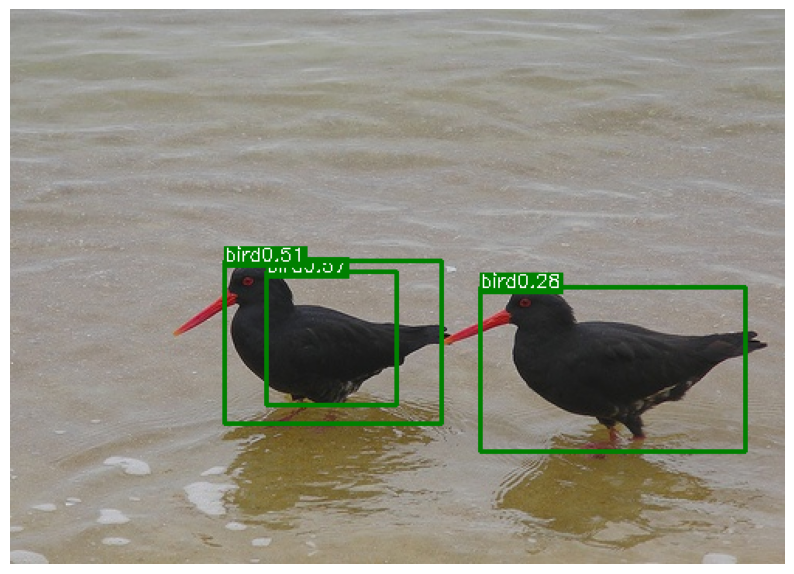

In [ ]:
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = predict_image(net, image_name, root_img_directory=file_root_test)

for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, p1, (p1[0] + text_size[0], p1[1] + text_size[1] + baseline), color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:07<00:00, 38.85it/s]


---class aeroplane ap 0.4359714244116416---
---class bicycle ap 0.6350097471890532---
---class bird ap 0.500361644829304---
---class boat ap 0.3069271897066308---
---class bottle ap 0.20093735689111059---
---class bus ap 0.6524570862763521---
---class car ap 0.6771648846957041---
---class cat ap 0.697538921033148---
---class chair ap 0.3093131436734188---
---class cow ap 0.5043356232559154---
---class diningtable ap 0.3936910895030861---
---class dog ap 0.6692210680295221---
---class horse ap 0.695106918674598---
---class motorbike ap 0.5681988708133273---
---class person ap 0.523008892588722---
---class pottedplant ap 0.18729335735800245---
---class sheep ap 0.42887877951551945---
---class sofa ap 0.47758636736569837---
---class train ap 0.6711922444533647---
---class tvmonitor ap 0.5284287716436377---
---map 0.5031311690953879---


# YOLO on the Video

In [ ]:
import cv2
import os

input_video_path = "/path/1721277-hd_1920_1080_25fps.mp4"
output_video_path = "/path/output_video.mp4"
temp_frame_dir = "/path/temp_frames/"
file_root_test = "/path/frame/"

os.makedirs(temp_frame_dir, exist_ok=True)

cap = cv2.VideoCapture(input_video_path)
fps = 15
target_size = (640, 360)

fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter(output_video_path, fourcc, fps, target_size)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    temp_filename = f"temp_{frame_idx}.jpg"
    temp_path = os.path.join(temp_frame_dir, temp_filename)
    cv2.imwrite(temp_path, frame)

    result = predict_image(net, temp_filename, root_img_directory=temp_frame_dir)
    box_thickness = 4
    font_scale = 0.8
    text_thickness = 2

    for left_up, right_bottom, class_name, _, prob in result:
        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(frame, left_up, right_bottom, color, box_thickness)
        label = f"{class_name} {round(prob, 2)}"
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(frame, p1, (p1[0] + text_size[0], p1[1] + text_size[1] + baseline), color, -1)
        cv2.putText(frame, label, (p1[0], p1[1] + text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), text_thickness)

    resized_frame = cv2.resize(frame, target_size)
    out.write(resized_frame)
    frame_idx += 1

cap.release()
out.release()
cv2.destroyAllWindows()


# ConvNext Yolo

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ConvNeXtYOLO(nn.Module):
    def __init__(self, S=14, B=2, num_classes=20, pretrained=True):
        super(ConvNeXtYOLO, self).__init__()
        self.S = S
        self.B = B
        self.C = num_classes
        convnext = models.convnext_tiny(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(convnext.children())[:-2])
        dummy_input = torch.randn(1, 3, 224, 224)
        dummy_out = self.backbone(dummy_input)
        in_channels = dummy_out.shape[1]
        self.conv_head = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, self.B * 5 + self.C, kernel_size=1)
        )
    def forward(self, x):
        features = self.backbone(x)
        out = self.conv_head(features)
        out = out.permute(0, 2, 3, 1)
        return out

def convnext_yolo(pretrained=True):
    model = ConvNeXtYOLO(S=14, B=2, num_classes=20, pretrained=pretrained)
    return model

In [ ]:
net = convnext_yolo().to(device)

In [ ]:
from importlib import reload
reload(yolo_loss)

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
best_test_loss = np.inf
learning_rate = learning_rate

os.makedirs('./checkpoints', exist_ok=True)
for epoch in range(num_epochs):
    net.train()
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')